In [3]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error,confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier




# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1, l2
from keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras.backend as K


2024-05-14 23:13:14.533544: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 23:13:14.572314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 23:13:14.572374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 23:13:14.573154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 23:13:14.578707: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 23:13:14.579195: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
parameter_data = pd.read_csv('../02_machine_learning/parameter_data_lead_time_also_FZ.csv')
parameter_data.drop(columns=['airport_id'], inplace=True)
parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [5]:
# For analyzis in dataframe only

parameter_data['time'] = pd.to_datetime(parameter_data['time'])

# Sort the DataFrame by 'timestamp' in ascending order
# Shift the 'metar' column by one hour
parameter_data['metar_lead_1'] = parameter_data['metar'].shift(-1)
parameter_data['metar_lead_2'] = parameter_data['metar'].shift(-2)

In [4]:
parameter_data

,Unnamed: 0,airport,time,contain_FZ,metar,metartype,air_temperature_0m,air_temperature_2m,relative_humidity_2m,precipitation_amount_acc,...,liquid_water_content_of_surface_snow_lead_4,liquid_water_content_of_surface_snow_lead_5,contain_FZ_lead_1,contain_FZ_lead_2,contain_FZ_lead_3,contain_FZ_lead_4,contain_FZ_lead_5,airport_id,metar_lead_1,metar_lead_2
0,0,ENAL,2021-01-01 01:00:00,False,ENAL 010120Z 08005KT 9999 FEW027/// SCT040/// ...,AUTO,5.98,2.12,0.809798,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010150Z 09006KT 9999 BKN025/// M01/M02 Q1...,ENAL 010320Z 09006KT 9999 OVC025/// 01/M02 Q1006=
1,1,ENAL,2021-01-01 02:00:00,False,ENAL 010150Z 09006KT 9999 BKN025/// M01/M02 Q1...,AUTO,5.84,1.90,0.826657,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010320Z 09006KT 9999 OVC025/// 01/M02 Q1006=,ENAL 010420Z 17003KT 9999 OVC028/// 01/M01 Q1006=
2,2,ENAL,2021-01-01 03:00:00,False,ENAL 010320Z 09006KT 9999 OVC025/// 01/M02 Q1006=,AUTO,5.79,1.63,0.865065,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010420Z 17003KT 9999 OVC028/// 01/M01 Q1006=,ENAL 010520Z 14006KT 9999 OVC031/// 02/M01 Q1006=
3,3,ENAL,2021-01-01 04:00:00,False,ENAL 010420Z 17003KT 9999 OVC028/// 01/M01 Q1006=,AUTO,5.81,1.67,0.869259,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010520Z 14006KT 9999 OVC031/// 02/M01 Q1006=,ENAL 010550Z 14008KT 9999 OVC030/// 02/M02 Q1006=
4,4,ENAL,2021-01-01 05:00:00,False,ENAL 010520Z 14006KT 9999 OVC031/// 02/M01 Q1006=,AUTO,5.99,2.06,0.839891,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010550Z 14008KT 9999 OVC030/// 02/M02 Q1006=,ENAL 010650Z 14006KT 9999 OVC025/// 02/M01 Q1006=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555308,555308,ENZV,2023-12-31 19:00:00,False,ENZV 311850Z 09018G29KT CAVOK 05/M04 Q0994=,MANUAL,1.45,2.29,0.667786,0.000810,...,0.0,0.0,False,False,False,False,False,53,ENZV 311950Z 10017KT CAVOK 05/M04 Q0994=,ENZV 312050Z 10018KT CAVOK 05/M04 Q0994=
555309,555309,ENZV,2023-12-31 20:00:00,False,ENZV 311950Z 10017KT CAVOK 05/M04 Q0994=,MANUAL,1.34,2.23,0.669755,0.005201,...,0.0,0.0,False,False,False,False,False,53,ENZV 312050Z 10018KT CAVOK 05/M04 Q0994=,ENZV 312220Z 10023G34KT CAVOK 05/M05 Q0994=
555310,555310,ENZV,2023-12-31 21:00:00,False,ENZV 312050Z 10018KT CAVOK 05/M04 Q0994=,MANUAL,1.11,2.02,0.669258,0.015085,...,0.0,0.0,False,False,False,False,False,53,ENZV 312220Z 10023G34KT CAVOK 05/M05 Q0994=,ENZV 312250Z 10021KT CAVOK 05/M04 Q0994=
555311,555311,ENZV,2023-12-31 22:00:00,False,ENZV 312220Z 10023G34KT CAVOK 05/M05 Q0994=,MANUAL,0.85,1.80,0.660101,0.023475,...,0.0,0.0,False,False,False,False,False,53,ENZV 312250Z 10021KT CAVOK 05/M04 Q0994=,None


In [6]:
# Train test split
X_train, X_test = train_test_split(parameter_data, test_size = 0.2, random_state=9)

### Downsampling the occurrences of FALSE for contain_FZ

In [7]:
downsampling_percentage = 0.033

fz_majority = X_train[X_train['contain_FZ'] == False]
fz_minority = X_train[X_train['contain_FZ'] == True]

print(f'Size of majority: {fz_majority.shape}')
print(f'Size of minority: {fz_minority.shape}')

majority_size = int(len(fz_majority) * downsampling_percentage)

# Downsample the majority class to match the minority class
downsampled_majority = resample(fz_majority, replace=False, n_samples=majority_size, random_state=42)
print(f'Size of downsampled majority: {downsampled_majority.shape}')

# Combine the downsampled majority class with the original minority class
downsampled_X_train = pd.concat([downsampled_majority, fz_minority])

Size of majority: (440007, 129)
Size of minority: (4243, 129)
Size of downsampled majority: (14520, 129)


In [5]:
X_train_downsampled = downsampled_X_train.drop(['contain_FZ'], axis=1)
X_train_fz = downsampled_X_train['contain_FZ']
y_train = downsampled_X_train[['contain_FZ_lead_2']]
y_test = X_test['contain_FZ_lead_2']
X_test_fz = X_test['contain_FZ']
#X_test = X_test.drop(['contain_FZ'], axis=1)

## F1-score 

In [6]:
def f1_score_calc(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Standardize features

In [7]:
data_params = ['air_temperature_0m', 'air_temperature_2m', 'relative_humidity_2m', 'x_wind_10m', 'y_wind_10m', 'fog_area_fraction', 'surface_air_pressure', 
               'air_pressure_at_sea_level', 'precipitation_amount_calculated',
              'air_temperature_pl_850', 'x_wind_pl_850', 'y_wind_pl_850', 'air_temperature_pl_925', 'x_wind_pl_925', 'y_wind_pl_925',
              'liquid_water_content_of_surface_snow']


In [8]:
data_params_lead_time = [f'{param}_lead_{lead_time}' for param in data_params for lead_time in range(1,3)]

In [9]:
data_params_lead_time

['air_temperature_0m_lead_1',
 'air_temperature_0m_lead_2',
 'air_temperature_2m_lead_1',
 'air_temperature_2m_lead_2',
 'relative_humidity_2m_lead_1',
 'relative_humidity_2m_lead_2',
 'x_wind_10m_lead_1',
 'x_wind_10m_lead_2',
 'y_wind_10m_lead_1',
 'y_wind_10m_lead_2',
 'fog_area_fraction_lead_1',
 'fog_area_fraction_lead_2',
 'surface_air_pressure_lead_1',
 'surface_air_pressure_lead_2',
 'air_pressure_at_sea_level_lead_1',
 'air_pressure_at_sea_level_lead_2',
 'precipitation_amount_calculated_lead_1',
 'precipitation_amount_calculated_lead_2',
 'air_temperature_pl_850_lead_1',
 'air_temperature_pl_850_lead_2',
 'x_wind_pl_850_lead_1',
 'x_wind_pl_850_lead_2',
 'y_wind_pl_850_lead_1',
 'y_wind_pl_850_lead_2',
 'air_temperature_pl_925_lead_1',
 'air_temperature_pl_925_lead_2',
 'x_wind_pl_925_lead_1',
 'x_wind_pl_925_lead_2',
 'y_wind_pl_925_lead_1',
 'y_wind_pl_925_lead_2',
 'liquid_water_content_of_surface_snow_lead_1',
 'liquid_water_content_of_surface_snow_lead_2']

In [10]:
all_data_params = data_params + data_params_lead_time

In [11]:
scaler = StandardScaler()

X_train_downsampled[all_data_params] = scaler.fit_transform(X_train_downsampled[all_data_params])
X_test[all_data_params] = scaler.transform(X_test[all_data_params])

## Embedding layer for airport id

In [12]:
#num_airports = len(parameter_data_embed['airport_id'].unique())
num_airports = len(parameter_data['airport_id'].unique())
print(f'Number of airports: {num_airports}')
input_aid = Input(shape=(1,))
output_dim = 20

embedding_layer = Embedding(input_dim=num_airports, output_dim=output_dim, name="embedding_airport")(input_aid)
flatten_airports = Flatten()(embedding_layer)

emb_cat = Reshape(target_shape=(output_dim,))(flatten_airports)

Number of airports: 54


## Model - BatchNormalization replaces Dropout

In [28]:
l1_lambda = 0.002

param_data_obs_dim = Input(shape=16,)
lead_time_data_dim = Input(shape=32,)
contain_fz_obs_dim = Input(shape=1,)

# Concatenate embedded categorical airport feature with param features
concat = Concatenate()([emb_cat, param_data_obs_dim, contain_fz_obs_dim, lead_time_data_dim])

dense_layer_1 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(concat)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dropout_1 = Dropout(0.2)(batch_norm_1)

dense_layer_2 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)

dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_2)
batch_norm_3 = BatchNormalization()(dense_layer_3)


#dense_layer_4 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(dense_layer_3)

#batch_norm_2 = BatchNormalization()(dense_layer_3)

#dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_2)
#batch_norm_3 = BatchNormalization()(dense_layer_3)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

# Output Layer
output_layer = Dense(units=1, activation='sigmoid')(batch_norm_3)

model = Model(inputs=[input_aid, param_data_obs_dim, contain_fz_obs_dim, lead_time_data_dim], outputs=output_layer)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_airport (Embeddi  (None, 1, 20)                1080      ['input_1[0][0]']             
 ng)                                                                                              
                                                                                                  
 flatten (Flatten)           (None, 20)                   0         ['embedding_airport[0][0]']   
                                                                                                  
 reshape (Reshape)           (None, 20)                   0         ['flatten[0][0]']       

In [30]:
# Compile the model
ml_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=ml_optimizer, metrics=[f1_score_calc])

In [31]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
history = model.fit([X_train_downsampled['airport_id'], X_train_downsampled[data_params], X_train_fz, X_train_downsampled[data_params_lead_time]], y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=1, callbacks=early_stopping)

Epoch 1/100


/home/tonjek/.local/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


470/470 [==============================] - 2s 2ms/step - loss: 2.4545 - f1_score_calc: 0.0267 - val_loss: 2.1317 - val_f1_score_calc: 0.0022
Epoch 2/100
470/470 [==============================] - 1s 2ms/step - loss: 0.7263 - f1_score_calc: 0.0677 - val_loss: 1.2353 - val_f1_score_calc: 0.1811
Epoch 3/100
470/470 [==============================] - 1s 2ms/step - loss: 0.3023 - f1_score_calc: 0.0899 - val_loss: 1.0553 - val_f1_score_calc: 0.4040
Epoch 4/100
470/470 [==============================] - 1s 2ms/step - loss: 0.1994 - f1_score_calc: 0.1123 - val_loss: 0.9341 - val_f1_score_calc: 0.4816
Epoch 5/100
470/470 [==============================] - 1s 2ms/step - loss: 0.1422 - f1_score_calc: 0.1057 - val_loss: 0.7573 - val_f1_score_calc: 0.5679
Epoch 6/100
470/470 [==============================] - 1s 2ms/step - loss: 0.1123 - f1_score_calc: 0.0894 - val_loss: 0.7204 - val_f1_score_calc: 0.5482
Epoch 7/100
470/470 [==============================] - 1s 1ms/step - loss: 0.0956 - f1_score_c

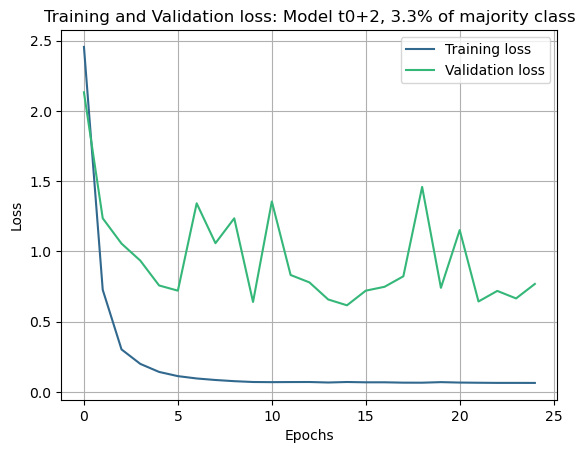

In [33]:
history = pd.DataFrame(history.history)
cmap_loss_val = sns.color_palette('viridis', 2)


plt.plot(history.loc[:, ['loss']], color= cmap_loss_val[0], label='Training loss')
plt.plot(history.loc[:, ['val_loss']], color = cmap_loss_val[1], label='Validation loss')
plt.title('Training and Validation loss: Model t0+2, 3.3% of majority class')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(True)

plt.savefig('training_validation_loss_t0+2_2.png')
plt.show()

## Prediction

In [34]:
# Make predictions
y_pred = model.predict([X_test['airport_id'], X_test[data_params], X_test_fz, X_test[data_params_lead_time]])

3471/3471 [==============================] - 2s 641us/step


In [35]:
y_pred_val = (y_pred > 0.4)
print(classification_report(y_test, y_pred_val))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00    109985
        True       0.59      0.24      0.34      1078

    accuracy                           0.99    111063
   macro avg       0.79      0.62      0.67    111063
weighted avg       0.99      0.99      0.99    111063



In [36]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

In [37]:
conf_matrix

array([[109808,    177],
       [   824,    254]])

In [38]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_val)

In [39]:
f1

0.3366467859509609

## ROC AUC

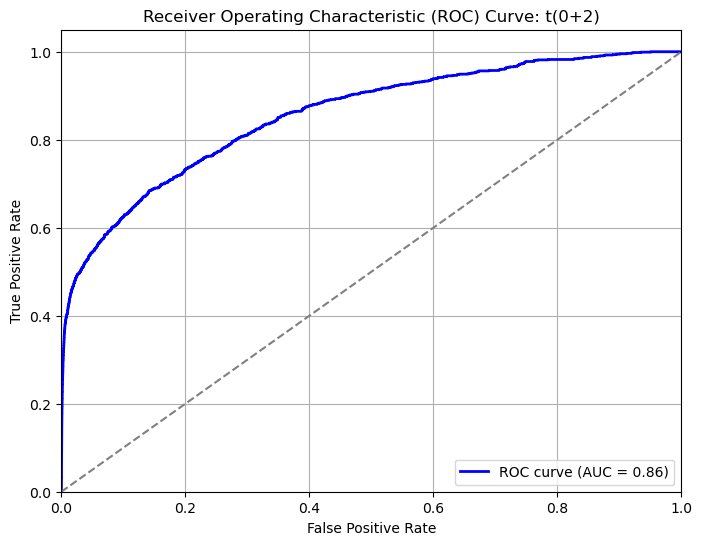

In [40]:

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: t(0+2)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('rocauc_lead2_2.png')
plt.show()

In [41]:
# Save y_pred as csv
#np.save('y_pred_t+2_2.npy', y_pred)

# Save corresponding y_test
#np.save('y_test_t+2_2.npy', y_test)

# Analyzation of data
The code from here and forward is for analyzation purposes. 

In [30]:
y_pred = y_pred.flatten()

In [36]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Time': X_test['time'], 'Airport': X_test['airport'], 'Metar': X_test['metar_lead_2'], 'Metartype': X_test['metartype']})

In [37]:
comparison_df.to_csv('comparison.csv', index=False)

In [38]:
pd.set_option('display.max_colwidth', 3000)

In [39]:
comparison_df[comparison_df['Predicted'] > 0.8].head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
330844,True,0.929302,2023-11-18 14:00:00,ENNM,ENNM 181550Z 06012KT 9999 BKN053/// M06/M07 Q1020 REFZRA=,AUTO
185624,True,0.919523,2023-12-26 17:00:00,ENGM,ENGM 261920Z 00000KT 0550 0350N R19R/0450D R01R/P2000N R19L/0400D R01L/P2000N FZFG VV001 M14/M15 Q0999 TEMPO 1500 BCFG=,MANUAL
389323,True,0.931356,2022-11-14 20:00:00,ENRO,ENRO 142150Z 00000KT 0500 R31/0900 FZFG OVC001 M04/M05 Q1019=,AUTO
177047,True,0.914930,2021-12-14 07:00:00,ENGM,ENGM 140850Z 18004KT 140V210 0350 R19R/0400N R01R/0400N R19L/0450N R01L/0400N FZFG VV002 M01/M01 Q1013 TEMPO 0600 FZFG=,MANUAL
340015,False,0.857509,2021-12-29 10:00:00,ENOL,ENOL 291220Z 13019KT 9999 VCSH FEW010 BKN030 M01/M03 Q0998 NOSIG=,MANUAL
391513,False,0.912742,2023-02-15 04:00:00,ENRO,ENRO 150550Z VRB01KT 5000 VCFG BKN005 OVC008 M10/M12 Q1019=,AUTO
329118,True,0.829409,2023-03-30 22:00:00,ENNM,ENNM 310020Z 06011KT 9999 -FZRA NCD M10/M13 Q1009=,AUTO
184364,True,0.818574,2023-11-02 14:00:00,ENGM,ENGM 021620Z 02010KT 5000 -FZDZ BR SCT005 BKN008 M01/M02 Q0995 TEMPO 4000 -FZRA BR BKN004=,MANUAL
326811,True,0.822909,2022-12-21 00:00:00,ENNM,ENNM 210150Z 07009KT 9999 OVC026 M02/M03 Q0995 REFZRA=,AUTO
305436,False,0.824149,2021-01-04 16:00:00,ENNA,ENNA 041820Z 18015KT CAVOK M02/M05 Q1027 RMK WIND 1800FT 21017KT=,MANUAL


In [63]:
only_true_fz = comparison_df[comparison_df['Actual'] == True]

In [64]:
only_false_fz = comparison_df[comparison_df['Actual'] == False]

In [65]:
only_true_fz.tail(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
499673,True,2.995391e-03,2021-02-07 08:00:00,ENTO,ENTO 070850Z 03009KT 360V050 9999 -FZDZ OVC017/// M06/M10 Q1029=,AUTO
327144,True,7.943688e-01,2023-01-04 01:00:00,ENNM,ENNM 040220Z 08014KT 9999 -FZRA NCD M06/M08 Q1018=,AUTO
177691,True,6.072437e-02,2022-01-12 00:00:00,ENGM,ENGM 120120Z 19009KT 0500 R19R/0450D R01R/0550N R19L/0550D R01L/0600N FZFG VV001 M04/M04 Q1023=,MANUAL
250874,True,7.451738e-01,2021-11-26 04:00:00,ENKR,ENKR 260520Z 18003KT 0350 R05/1800N R23/0600N FZFG VV001 M21/M23 Q0998 RMK WIND 731FT 10005KT=,MANUAL
330872,True,5.050412e-02,2023-11-19 18:00:00,ENNM,ENNM 191920Z 06011KT 9999 -FZRA NCD M08/M11 Q1010=,MANUAL
144382,True,4.400560e-01,2022-11-27 11:00:00,ENDU,ENDU 271150Z 00000KT 9999 VCSH SCT040 BKN060 M04/M05 Q1018 TEMPO -FZDZ RMK WIND 1100FT 15007KT WIND 2200FT 16015KT=,COR
330897,True,8.461687e-01,2023-11-20 19:00:00,ENNM,ENNM 201950Z 11008KT 060V130 9999 NCD M06/M11 Q1022 REFZRA=,AUTO
428330,True,4.847721e-04,2023-03-08 19:00:00,ENSG,ENSG 082020Z 00000KT 1000 FZFG FEW/// SCT001 M10/M11 Q0990 RMK WIND 3806FT 35007KT=,MANUAL
30531,True,1.922303e-04,2022-02-18 03:00:00,ENAT,ENAT 180420Z 08018KT 9999 SCT049/// M02/M07 Q0986 RESHUP REFZUP RMK WIND 700FT 07024KT=,AUTO
282775,True,2.008580e-01,2023-12-09 12:00:00,ENMH,ENMH 091250Z 19026KT 7000 FZDZ NCD M09/M12 Q1016=,AUTO


<AxesSubplot: >

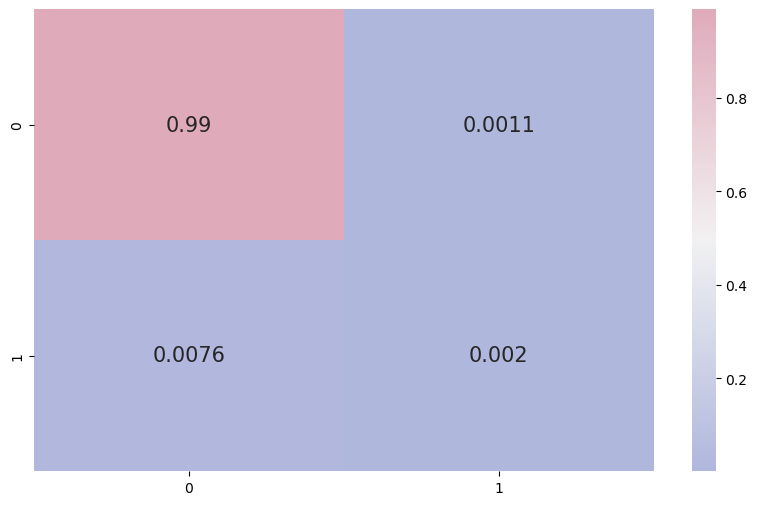

In [59]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

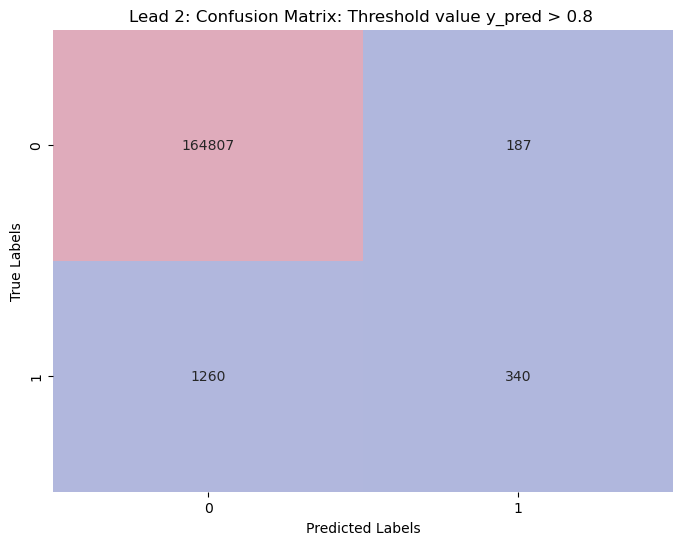

In [60]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap1, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lead 2: Confusion Matrix: Threshold value y_pred > 0.8 ')
#plt.savefig('cmap_lead2_.png')
plt.show()

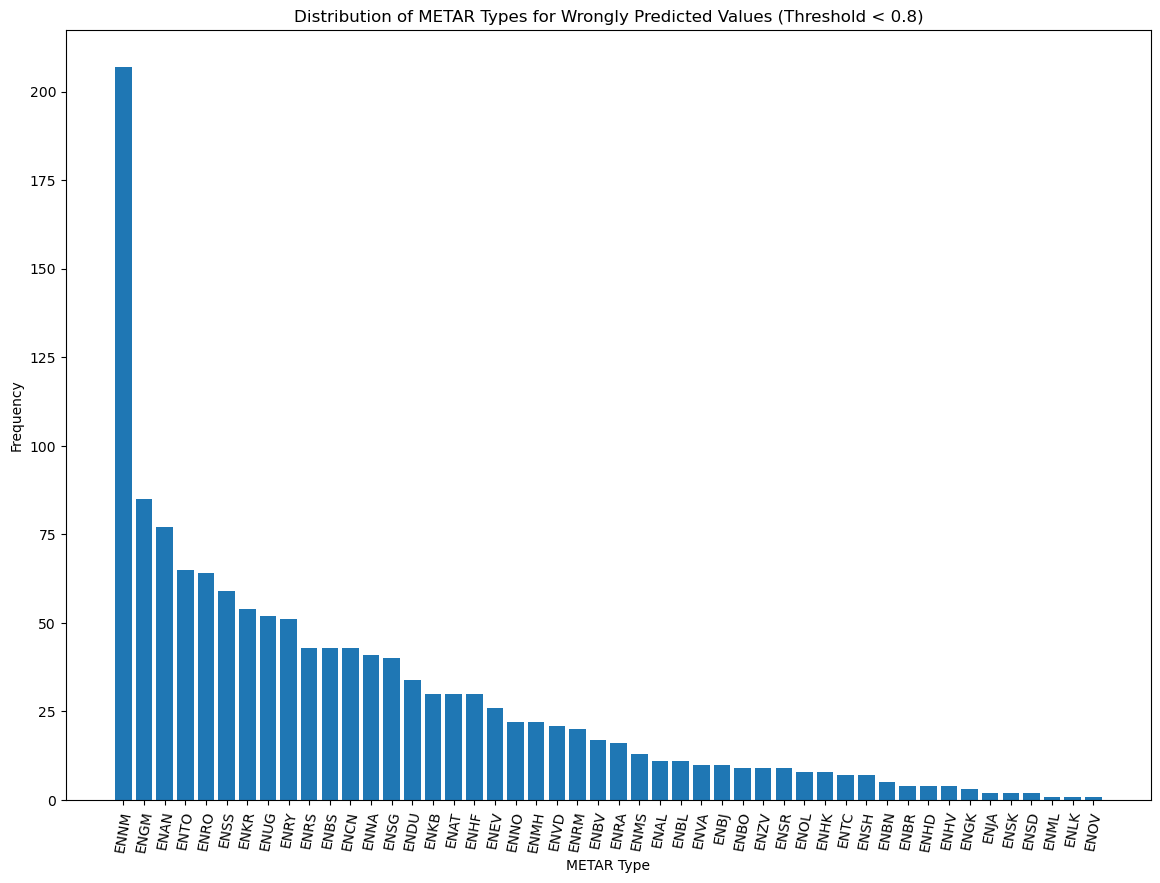

In [68]:
wrongly_predicted_df = only_true_fz[(only_true_fz['Predicted'] < 0.8)]

metar_type_counts = wrongly_predicted_df['Airport'].value_counts()

plt.figure(figsize=(14, 10))
plt.bar(metar_type_counts.index, metar_type_counts.values)
plt.xlabel('METAR Type')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold < 0.8)')
plt.xticks(rotation=80)
plt.show()

<Figure size 1400x1000 with 0 Axes>

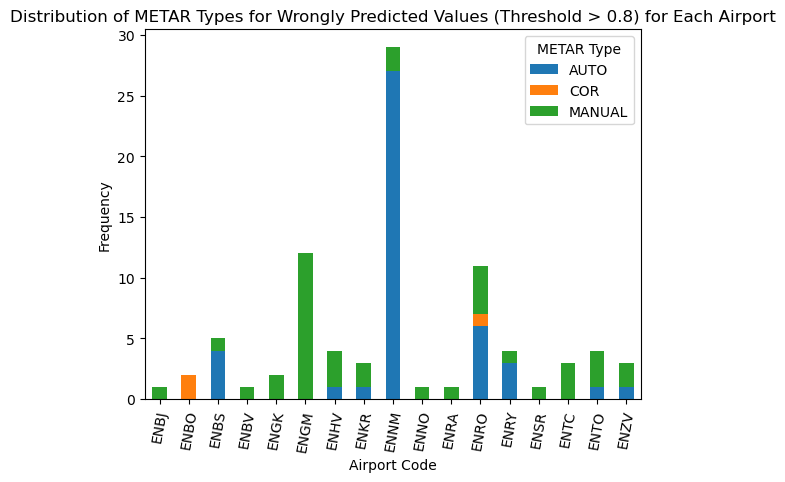

In [69]:
wrongly_predicted_false_df = comparison_df[(comparison_df['Actual'] == False) & (comparison_df['Predicted'] >= 0.8)]


metar_type_counts_per_airport = wrongly_predicted_false_df.groupby(['Airport', 'Metartype']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 10)) 
metar_type_counts_per_airport.plot(kind='bar', stacked=True)
plt.xlabel('Airport Code')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold > 0.8) for Each Airport')
plt.xticks(rotation=80)
plt.legend(title='METAR Type')
plt.show()

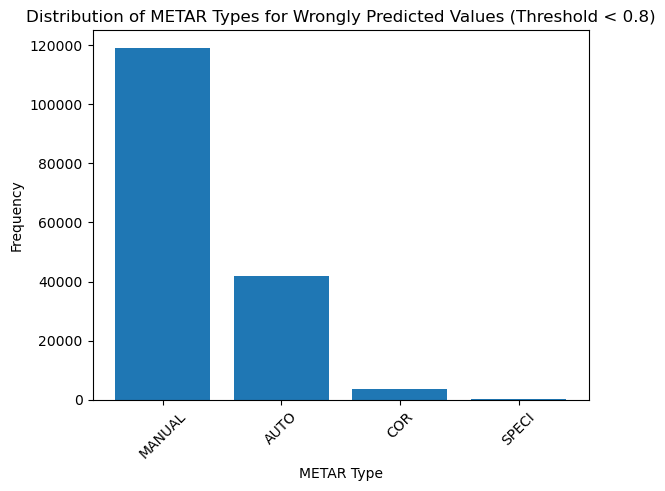

In [72]:
wrongly_predicted_df = only_false_fz[(only_false_fz['Predicted'] < 0.8)]

metar_type_counts = wrongly_predicted_df['Metartype'].value_counts()

plt.bar(metar_type_counts.index, metar_type_counts.values)
plt.xlabel('METAR Type')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold < 0.8)')
plt.xticks(rotation=45)
plt.show()

In [73]:
only_false_fz.head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
320059,False,0.008396,2023-10-19 17:00:00,ENNA,ENNA 191820Z VRB02KT CAVOK M00/M06 Q1025 RMK WIND 1800FT 26018KT=,MANUAL
514985,False,0.004194,2022-03-26 09:00:00,ENUG,ENUG 260950Z 35032KT 9999NDV /// M05/M15 Q1019 W///S4=,AUTO
445872,False,0.003663,2022-12-03 06:00:00,ENSK,ENSK 030650Z 15013KT 9999 NCD 02/M01 Q1036=,AUTO
490498,False,0.000464,2022-04-20 17:00:00,ENTC,ENTC 201750Z 31004KT 270V340 CAVOK 08/02 Q1025 NOSIG RMK WIND 2600FT 24010KT=,MANUAL
183690,False,0.001468,2023-04-26 23:00:00,ENGM,ENGM 262350Z 26003KT 240V300 CAVOK 00/M03 Q1004=,MANUAL
138911,False,0.001539,2021-11-20 16:00:00,ENDU,ENDU 201650Z 29010KT 9999 FEW034/// BKN043/// OVC096/// M02/M04 Q0997 RMK WIND 1100FT 31011KT WIND 2200FT 34013KT=,AUTO
166857,False,0.000235,2021-03-03 20:00:00,ENFL,ENFL 032120Z 36015KT 9999 -SHRA FEW020 SCT040 02/M05 Q1026=,MANUAL
404365,False,0.006782,2021-02-16 10:00:00,ENRY,ENRY 161050Z 09003KT 9999 SCT005 OVC021 M02/M03 Q1017 NOSIG=,MANUAL
395799,False,0.001083,2023-12-30 10:00:00,ENRO,ENRO 301050Z 09005KT 9999 FEW037/// M08/M10 Q0998=,AUTO
296467,False,0.000296,2021-12-19 15:00:00,ENMS,ENMS 191550Z 34013KT 9999 -SHRA SCT016 SCT024 04/01 Q1020 RMK WIND 412FT 30006KT=,MANUAL


### Look at characteristics for wrongly predicted True and False

Check the occurrence of SN and RA for predictions over threshold where contain_FZ = FALSE

In [134]:
wrongly_predicted_true = comparison_df[(comparison_df['Actual'] == False) & (comparison_df['Predicted'] >= 0.8)]

filtered_wrongly_predicted_true = wrongly_predicted_true[wrongly_predicted_true['Metar'].str.contains(r'\bRA|\bSN')]


In [135]:
filtered_wrongly_predicted_df

,Actual,Predicted,Time,Airport,Metar,Metartype
505935,False,0.884623,2023-01-07 17:00:00,ENTO,ENTO 071750Z 33004KT 280V350 2400 -RA VV003 00/00 Q1003 BECMG 16010KT=,MANUAL
327071,False,0.804635,2023-01-01 01:00:00,ENNM,ENNM 010220Z 25020KT 9999 -SN SCT030 BKN062 00/M04 Q0995=,AUTO
494760,False,0.902860,2023-03-09 03:00:00,ENTC,ENTC 090350Z 19017KT 2100 -SN VV013 M05/M07 Q0985 RMK WIND 2600FT 29024G35KT=,MANUAL
327235,False,0.920041,2023-01-07 20:00:00,ENNM,ENNM 072120Z 10020KT 6000 -SN NCD M01/M03 Q0998=,AUTO
229103,False,0.876006,2023-03-31 13:00:00,ENHV,ENHV 311420Z 35030G46KT 1500 SN VV009 M01/M01 Q0997=,MANUAL
331469,False,0.873217,2023-12-15 03:00:00,ENNM,ENNM 150420Z 08012KT 4200 -SN BKN001/// BKN003/// OVC017/// M07/M09 Q1011=,AUTO
252482,False,0.862668,2022-02-02 23:00:00,ENKR,ENKR 030020Z 17003KT 0150 R05/1000N R23/0600N +SN VV001 M17/M19 Q1013 RMK WIND 731FT 03010KT=,MANUAL
174063,False,0.851598,2021-01-30 02:00:00,ENGM,ENGM 300320Z VRB01KT 1300 R19R/P2000N R01R/1800D R19L/1100D R01L/1500U -SN BR OVC002 M15/M17 Q1000=,MANUAL
229107,False,0.858445,2023-03-31 17:00:00,ENHV,ENHV 311750Z 35030G43KT 3000 -SN VV018 M00/M02 Q1000=,MANUAL
109338,False,0.880295,2023-04-01 11:00:00,ENBS,ENBS 011150Z 35022KT 5000 -SN SCT027/// BKN037/// OVC049/// M03/M06 Q////=,AUTO


Look at characteristics for wrongly predicted false

In [97]:
wrongly_predicted_false = comparison_df[(comparison_df['Actual'] == True) & (comparison_df['Predicted'] <= 0.4)]

filtered_wrongly_predicted_false = wrongly_predicted_false[wrongly_predicted_false['Metar'].str.contains(r'\bRA|\bSN')]


In [99]:
filtered_wrongly_predicted_false.head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
517321,True,1.794793e-02,2023-03-05 12:00:00,ENUG,ENUG 051250Z 29017KT 270V340 0550NDV +SN NCD M05/M07 Q1000 REFZRA W///S4=,AUTO
215814,True,1.400332e-01,2023-02-11 01:00:00,ENHK,ENHK 110150Z 26023G35KT 3600 -SN FEW010/// SCT046/// M02/M05 Q0989 REFZDZ=,AUTO
277596,True,1.424869e-01,2022-12-27 09:00:00,ENMH,ENMH 270950Z 19026KT 9999 -SN NCD M01/M03 Q0994 REFZDZ=,AUTO
243765,True,2.549322e-03,2023-03-26 06:00:00,ENKB,ENKB 260720Z VRB03KT 9999 -SN FEW005/// SCT012/// BKN021/// M02/M06 Q1002 REFZUP RMK WIND 745FT 20008KT=,AUTO
391373,True,2.672997e-01,2023-02-09 02:00:00,ENRO,ENRO 090250Z 19014G25KT 160V220 9999 -SN OVC029/// 02/M03 Q0997 REFZRA=,AUTO
519886,True,1.190089e-03,2021-01-23 09:00:00,ENVA,ENVA 230950Z 12005KT 9999 -FZDZ SCT009 OVC072 M02/M03 Q0979 TEMPO 2000 SN VV008 RMK WIND 670FT 15003KT=,MANUAL
517454,True,2.028487e-01,2023-03-11 01:00:00,ENUG,ENUG 110220Z 24026G40KT 6000NDV -SN FEW010/// BKN020/// BKN046/// M02/M05 Q0980 REFZRA W///S6=,AUTO
469996,True,1.110962e-03,2023-02-02 13:00:00,ENSS,ENSS 021350Z 36004KT 2000 -SN SCT009/// BKN032/// OVC048/// M03/M05 Q1009 REFZDZ RMK WIND 0500FT VRB10KT=,MANUAL
400836,True,4.912246e-03,2023-03-20 22:00:00,ENRS,ENRS 202320Z 25022KT 9999 -SN FEW006/// SCT024/// BKN042/// 01/M04 Q0999 REFZRA=,AUTO
173791,True,2.834710e-03,2021-01-18 18:00:00,ENGM,ENGM 181920Z 01003KT 1000 R19R/1600D R01R/0900N R19L/1300D R01L/1200N FZFG VV003 M06/M07 Q1007 TEMPO 2000 -SN BR=,COR
